In [291]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn import datasets
from sklearn.metrics import silhouette_score
import plotly
import plotly.express as px

df = pd.read_csv('Sample-Superstore - Sample-Superstore.tsv', delimiter = "\t")

In [292]:
for col in df:
    df.rename(columns={col: col.lower().replace(' ', '').replace('-', '')}, inplace=True)

In [293]:
import warnings
warnings.filterwarnings('ignore')

In [373]:
# finding if there are any duplicates in the Customer Name and/or ID

for c, d in df.groupby("customername"):
    i=0
    for id, d1 in d.groupby("customerid"):
        i += 1
    if i > 1:
        print(c,d)
        break

df.nunique()

rowid           9994
orderid         5009
orderdate       1237
shipdate        1334
shipmode           4
customerid       793
customername     793
segment            3
country            1
city             531
state             49
postalcode       631
region             4
productid       1862
category           3
subcategory       17
productname     1850
sales           5825
quantity          14
discount          12
profit          7287
dtype: int64

# Special categories
## Creating new categories

In [295]:
df_monetary = df.groupby('customerid')['sales'].sum()
df_monetary = df_monetary.reset_index()

In [296]:
df_frequency = df.groupby('customerid')['orderid'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['customerid', 'order_count']

In [297]:
import datetime as dt

df['orderdate'] = pd.to_datetime(df['orderdate'])

# Calculate the most recent order date
most_recent_date = df['orderdate'].max()

# Subtract the order date from the most recent date
df_recency = df.groupby('customerid')['orderdate'].max().reset_index()
df_recency['recency'] = (most_recent_date - df_recency['orderdate']).dt.days
df_recency.drop('orderdate', axis=1, inplace=True)

In [298]:
df_combined = pd.merge(df_monetary, df_frequency, on='customerid')
df_combined = pd.merge(df_combined, df_recency, on='customerid')
df_combined.head()

,customerid,sales,order_count,recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


## Box plot

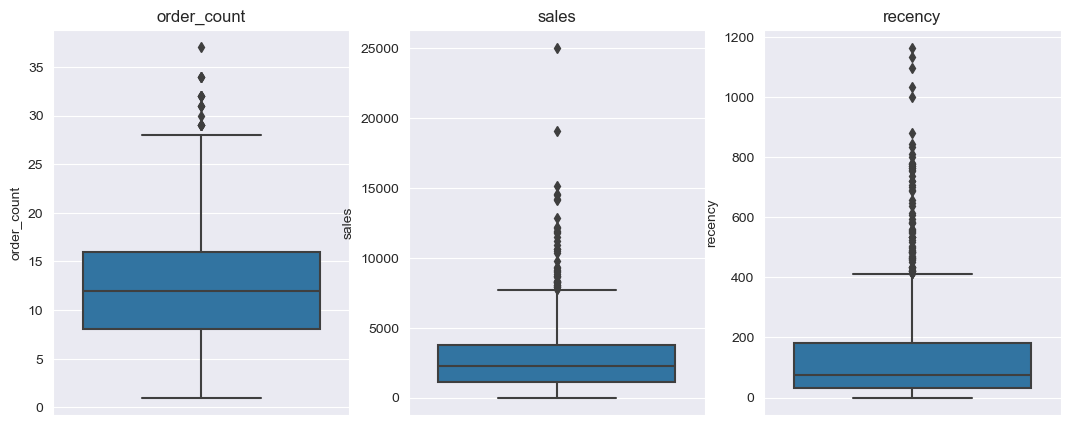

In [299]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='order_count', data=df_combined, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='sales', data=df_combined , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='recency', data=df_combined , ax=axes[2])
axes[2].set_title('recency')

plt.show()

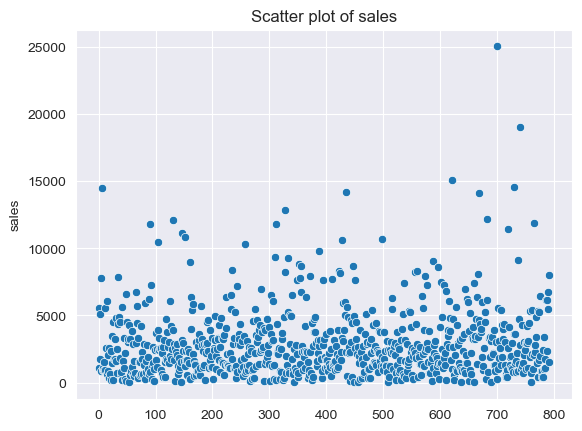

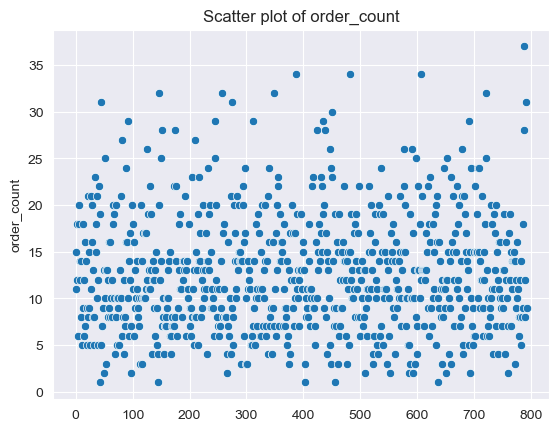

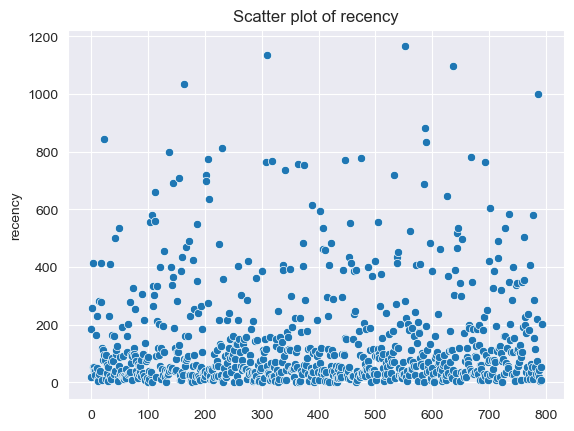

In [300]:
for column in df_combined.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_combined[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

## Remove outliers

In [301]:
q1 =df_combined.quantile(0.25)
q3 =df_combined.quantile(0.75)
iqr = q3 - q1
df_combined =df_combined[~((df_combined < (q1 - 1.5 * iqr)) |(df_combined > (q3 + 1.5 * iqr))).any(axis=1)]
print(df_combined.shape)

(668, 4)


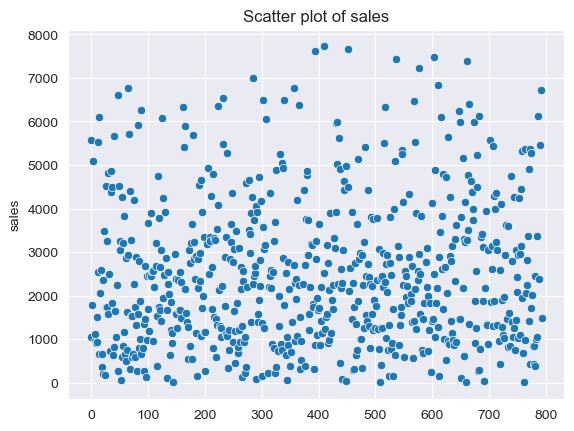

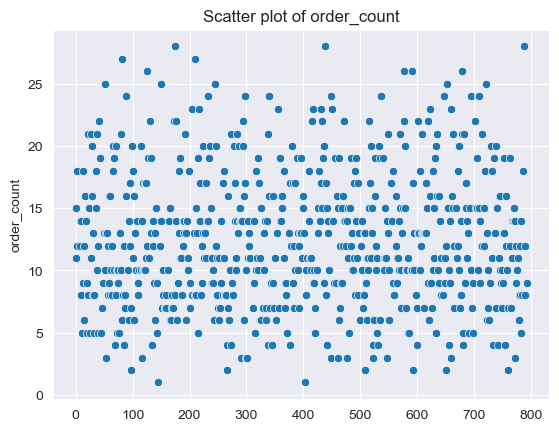

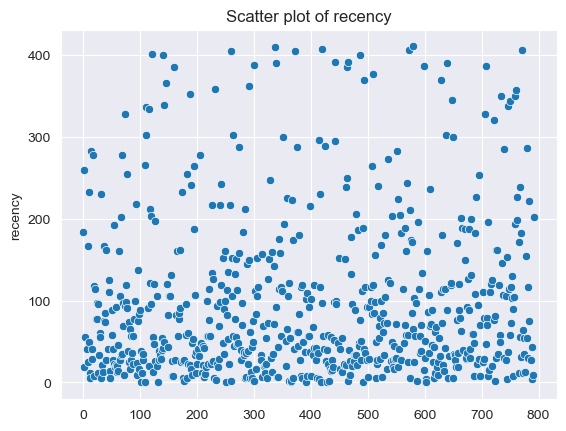

In [302]:
for column in df_combined.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_combined[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

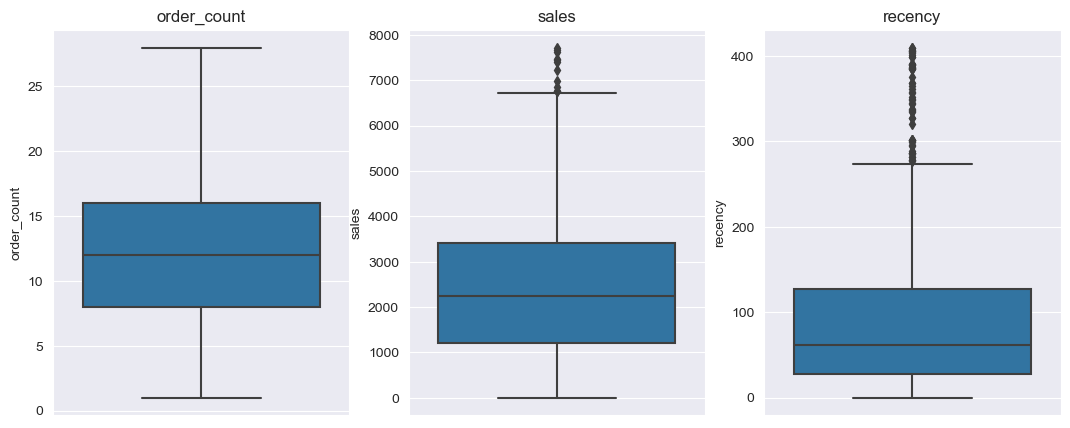

In [305]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='order_count', data=df_combined, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='sales', data=df_combined , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='recency', data=df_combined , ax=axes[2])
axes[2].set_title('recency')

plt.show()

## Scaler

In [304]:
# Rescaling the attributes
rfm_df = df_combined[['sales', 'order_count', 'recency']]

scaler = StandardScaler()

# fit transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['sales', 'order_count', 'recency']
rfm_df_scaled.head()

,sales,order_count,recency
0,1.815723,-0.261677,0.876012
1,-0.863557,0.472007,-0.812704
2,-0.427160,-0.078256,1.643610
3,1.532394,1.022270,-0.444257
4,-0.916868,-0.078256,-0.587542


## Finding how many clusters are needed

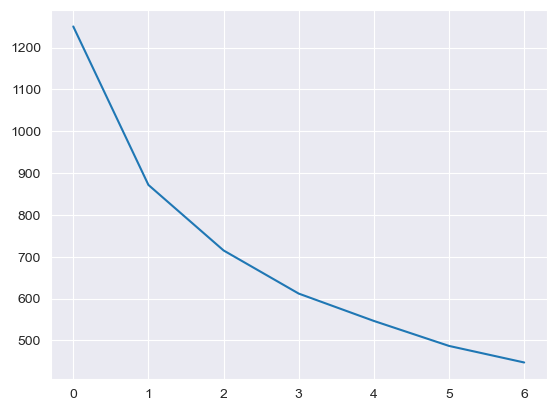

In [306]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

plt.plot(ssd)

For n_clusters=2, the silhouette score is 0.3400103700052583
For n_clusters=3, the silhouette score is 0.36305686713690394
For n_clusters=4, the silhouette score is 0.3182268144392149
For n_clusters=5, the silhouette score is 0.32845273388567403
For n_clusters=6, the silhouette score is 0.32469108576809813
For n_clusters=7, the silhouette score is 0.2762216753963712
For n_clusters=8, the silhouette score is 0.2820118017423266


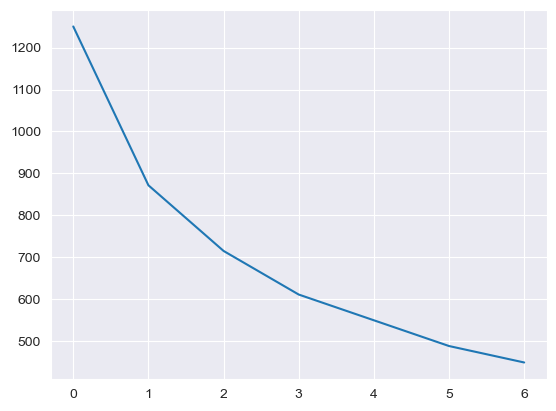

In [307]:
# Silhouette analysis
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

## Build model

In [308]:
features = rfm_df_scaled[['sales', 'order_count', 'recency']]

# Create and fit the K-means model
kmeans = KMeans(n_clusters=3)
kmeans.fit(features)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_
sorted(Counter(cluster_labels).items())

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

print("Cluster Labels:")
print(cluster_labels)
print("\nCluster Centroids:")
print(centroids)

Cluster Labels:
[1 2 0 1 2 2 2 2 0 1 1 0 1 2 0 2 2 2 1 1 2 1 2 1 2 2 1 0 2 1 1 1 2 2 2 1 1
 2 2 2 1 1 2 1 2 1 0 2 2 2 1 2 1 2 2 2 1 1 1 1 0 1 2 2 2 0 1 2 0 2 2 1 2 1
 2 2 2 2 2 1 2 2 0 2 2 2 2 2 1 2 1 2 1 1 2 2 0 0 0 2 1 0 0 1 0 2 0 1 2 1 1
 2 1 2 1 1 2 2 2 2 2 2 2 0 2 0 0 2 1 2 2 2 2 2 2 2 0 1 1 1 2 2 2 2 2 1 0 1
 1 1 2 1 1 0 1 2 2 0 2 0 1 1 1 1 0 0 1 2 2 1 2 2 2 1 2 2 1 1 2 2 2 1 1 2 1
 2 2 1 2 1 1 0 2 2 2 2 0 1 1 1 2 1 2 1 2 0 2 1 1 1 2 2 2 2 2 2 2 1 2 0 0 2
 1 2 0 2 2 2 2 1 2 2 2 1 2 0 2 1 1 1 0 2 1 0 1 1 1 2 1 1 0 1 1 1 1 2 1 1 1
 0 2 1 1 2 2 2 1 2 2 1 2 2 1 2 1 2 1 1 2 2 1 0 2 2 1 2 2 1 0 0 1 2 2 2 2 2
 1 2 2 2 0 0 1 2 1 0 2 2 2 1 1 2 0 2 2 2 0 1 0 1 1 1 1 2 1 2 2 2 1 1 2 2 2
 2 1 1 1 2 0 2 1 2 2 2 2 2 1 1 2 2 2 0 2 1 2 0 2 2 2 0 2 1 1 1 1 1 1 1 1 2
 1 1 2 2 0 0 1 1 2 1 1 1 2 1 2 1 2 2 0 0 0 0 2 2 1 1 2 1 1 2 2 2 1 2 2 0 1
 0 1 2 2 0 2 1 1 0 1 1 0 1 2 2 2 2 1 2 2 2 2 0 2 0 2 2 2 2 1 1 1 0 1 1 2 2
 2 2 1 1 2 2 2 2 0 1 1 2 1 1 2 2 0 2 2 1 2 2 1 2 0 1 0 2 0 1 0 2 2 2 0 2 2
 1 0 1 1 

## Visualize Model

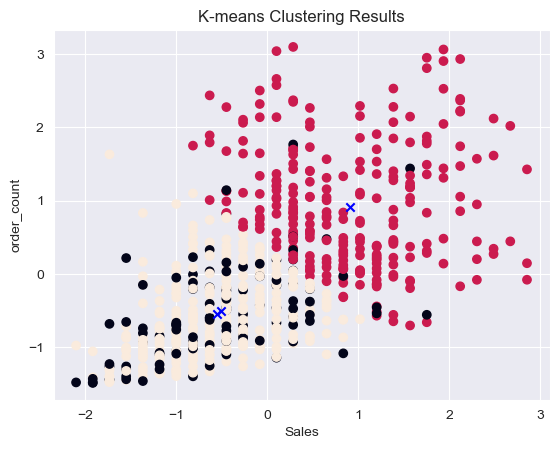

In [309]:
labels = kmeans.labels_

plt.scatter(rfm_df_scaled['order_count'], rfm_df_scaled['sales'], c=labels)
plt.scatter(centroids[:,1], centroids[:,1], marker='x', c= 'blue')
plt.xlabel('Sales')
plt.ylabel('order_count')
plt.title('K-means Clustering Results')
plt.show()

In [310]:
fig = px.scatter_3d(rfm_df, x="order_count", y="sales", z="recency", color=kmeans.labels_)
fig.update_layout(autosize = True, width = 700, height = 700)
plotly.offline.iplot(fig, filename='simple-3d-scatter')

# Sales Categories per Customer
## Creating new categories

In [311]:
df_sales = df.groupby('customerid')['sales'].sum()
df_sales = df_sales.reset_index()

In [312]:
df_profit = df.groupby('customerid')['profit'].sum()
df_profit = df_profit.reset_index()

In [313]:
df_discount = round((df.groupby('customerid')['discount'].mean())*100, 2)
df_discount = df_discount.reset_index()

In [315]:
df_mix = pd.merge(df_sales, df_profit, on='customerid')
df_mix = pd.merge(df_mix, df_discount, on='customerid')
df_mix.head()

,customerid,sales,profit,discount
0,AA-10315,5563.560,-362.8825,9.09
1,AA-10375,1056.390,277.3824,8.00
2,AA-10480,1790.512,435.8274,1.67
3,AA-10645,5086.935,857.8033,6.39
4,AB-10015,886.156,129.3465,6.67


## EDA with outliers

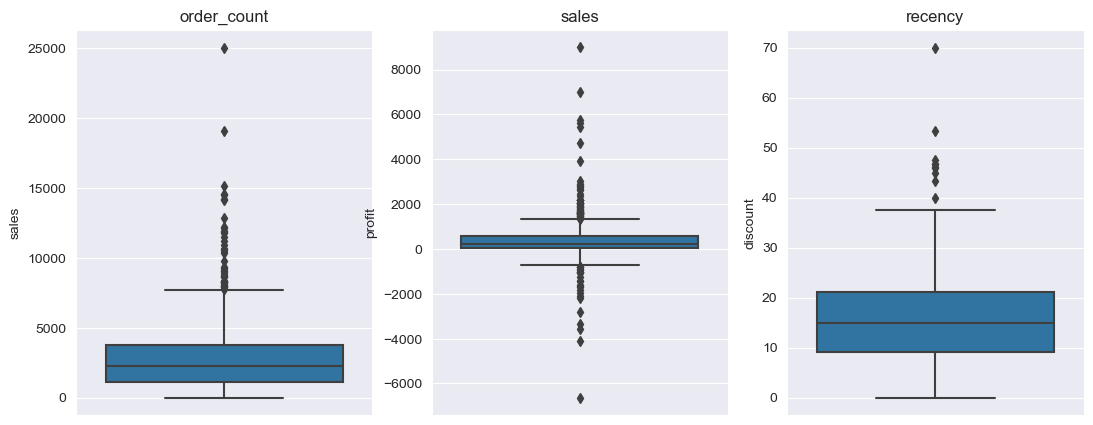

In [316]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='sales', data=df_mix, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='profit', data=df_mix , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='discount', data=df_mix , ax=axes[2])
axes[2].set_title('recency')

plt.show()

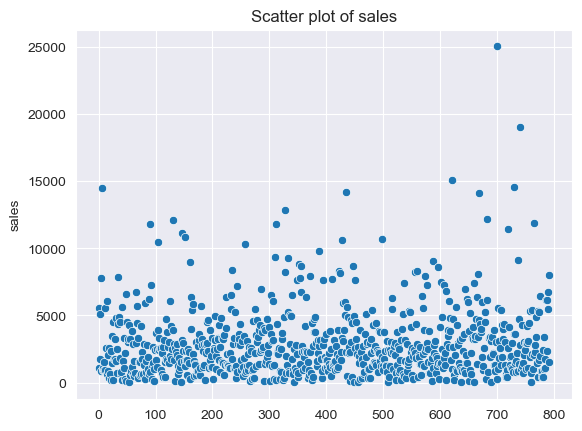

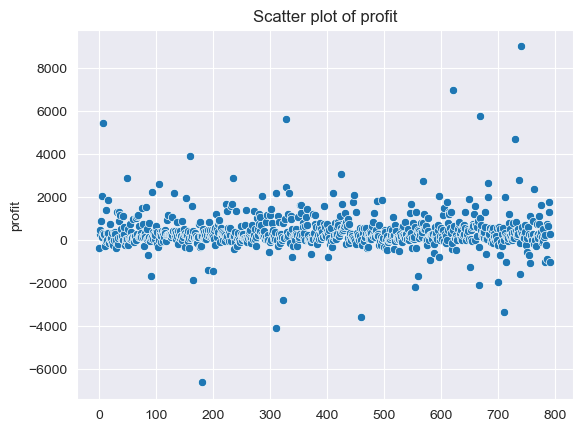

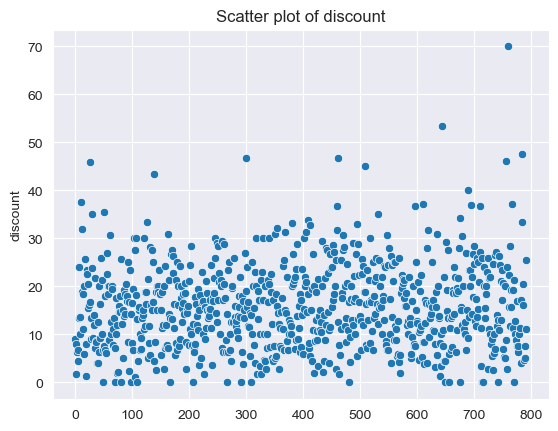

In [327]:
for column in df_mix.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_mix[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

## Remove outliers

In [345]:
df_mix.head()

,customerid,sales,profit,discount
0,AA-10315,5563.560,-362.8825,9.09
1,AA-10375,1056.390,277.3824,8.00
2,AA-10480,1790.512,435.8274,1.67
3,AA-10645,5086.935,857.8033,6.39
4,AB-10015,886.156,129.3465,6.67


In [319]:
q1 =df_mix.quantile(0.25)
q3 =df_mix.quantile(0.75)
iqr = q3 - q1
df_mix_clean =df_mix[~((df_mix < (q1 - 1.5 * iqr)) |(df_mix > (q3 + 1.5 * iqr))).any(axis=1)]
print(df_mix_clean.shape)

(695, 4)


## EDA witout outliers

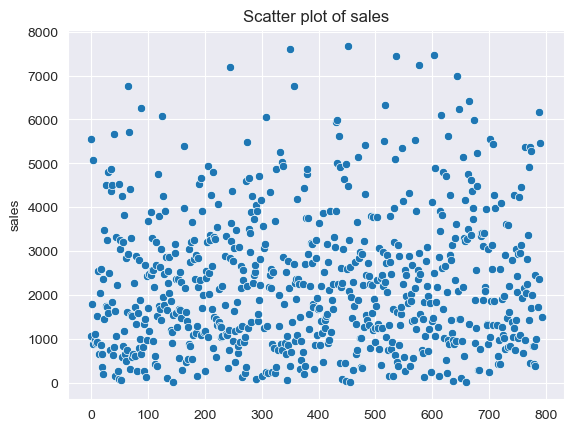

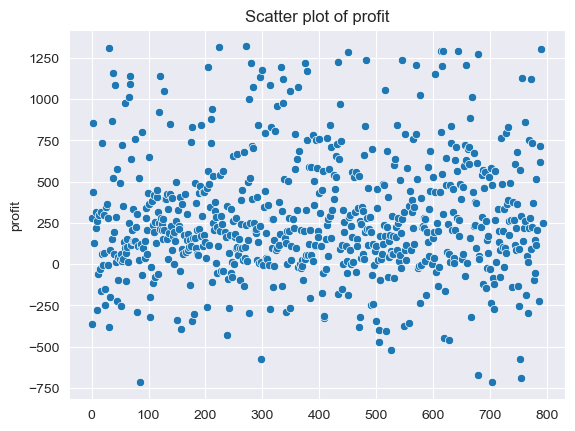

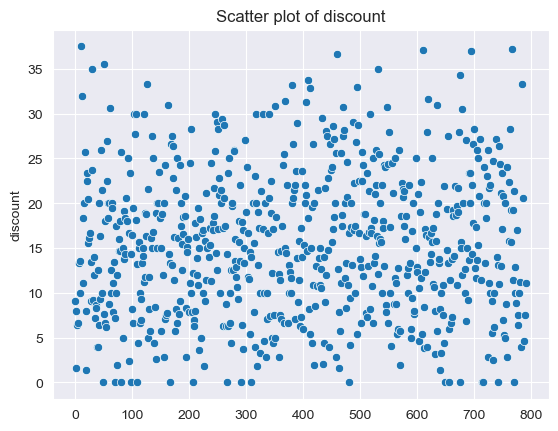

In [320]:
for column in df_mix_clean.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_mix_clean[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

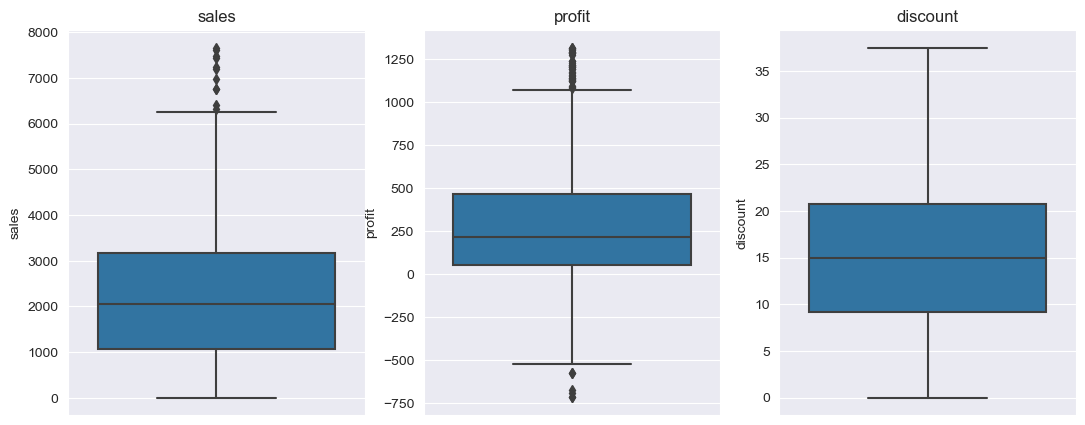

In [341]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='sales', data=df_mix_clean, ax=axes[0])
axes[0].set_title('sales')

sns.boxplot(y='profit', data=df_mix_clean , ax=axes[1])
axes[1].set_title('profit')

sns.boxplot(y='discount', data=df_mix_clean , ax=axes[2])
axes[2].set_title('discount')

plt.show()

## Scaler

In [347]:
# Rescaling the attributes
df_mix_cat = df_mix_clean[['sales', 'profit', 'discount']]

scaler = StandardScaler()

# fit transform
df_mix_cat_scaled = scaler.fit_transform(df_mix_cat)
df_mix_cat_scaled.shape

df_mix_cat_scaled = pd.DataFrame(df_mix_cat_scaled)
df_mix_cat_scaled.columns = [['sales', 'profit', 'discount']]
df_mix_cat_scaled.head()

,sales,profit,discount
0,2.109976,-1.746040,-0.783790
1,-0.793395,-0.000738,-0.919070
2,-0.320497,0.431168,-1.704689
3,1.802949,1.581435,-1.118888
4,-0.903054,-0.404270,-1.084137


## Finding how many clusters are needed

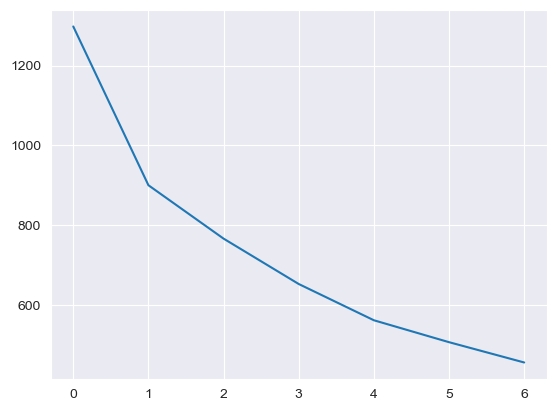

In [323]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_mix_cat_scaled)

    ssd.append(kmeans.inertia_)

plt.plot(ssd)

## Build model

In [344]:
df_mix_cat_scaled.head()

,sales,profit,discount
0,2.109976,-1.746040,-0.783790
1,-0.793395,-0.000738,-0.919070
2,-0.320497,0.431168,-1.704689
3,1.802949,1.581435,-1.118888
4,-0.903054,-0.404270,-1.084137


In [338]:
features = df_mix_cat_scaled[['sales', 'profit', 'discount']]

# Create and fit the K-means model
kmeans = KMeans(n_clusters=3)
kmeans.fit(features)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_
sorted(Counter(cluster_labels).items())

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

## Visualize Model

In [343]:
fig = px.scatter_3d(df_mix_cat, x="sales", y="profit", z="discount", color=kmeans.labels_)
fig.update_layout(autosize = True, width = 800, height = 800)
plotly.offline.iplot(fig, filename='simple-3d-scatter')

# Sales Categories per Product
## Creating new categories

In [352]:
df_sales_prod = df.groupby('productid')['sales'].sum()
df_sales_prod = df_sales_prod.reset_index()

In [353]:
df_profit_prod = df.groupby('productid')['profit'].sum()
df_profit_prod = df_profit_prod.reset_index()

In [354]:
df_discount_prod = round((df.groupby('productid')['discount'].mean())*100, 2)
df_discount_prod = df_discount_prod.reset_index()

In [366]:
df_mix_prod = pd.merge(df_sales_prod, df_profit_prod, on='productid')
df_mix_prod = pd.merge(df_mix_prod, df_discount_prod, on='productid')
display(df_mix_prod.shape)
df_mix_prod.head()

(1862, 4)

,productid,sales,profit,discount
0,FUR-BO-10000112,825.174,-117.8820,30.00
1,FUR-BO-10000330,1064.624,24.1960,10.00
2,FUR-BO-10000362,2154.348,311.1836,13.00
3,FUR-BO-10000468,723.842,-133.1092,18.33
4,FUR-BO-10000711,851.760,229.9752,0.00


## EDA with outliers

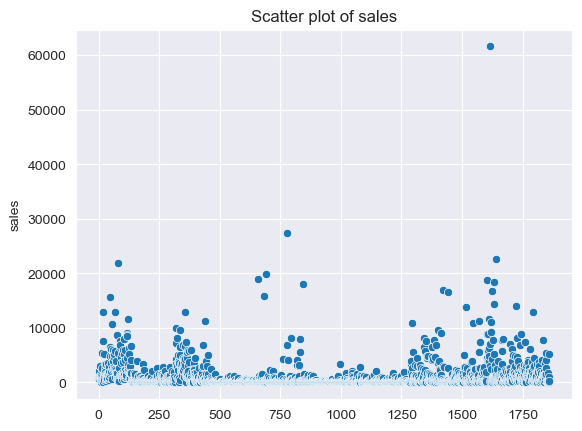

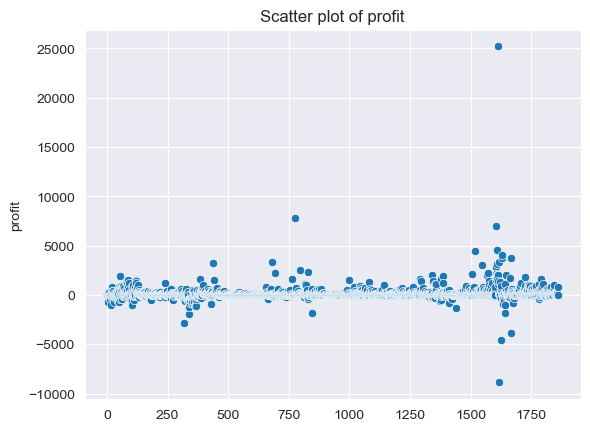

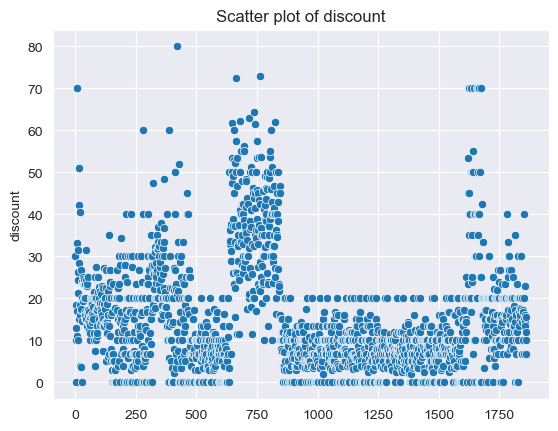

In [356]:
for column in df_mix.columns:
    if column != 'productid':
        sns.scatterplot(data=df_mix_prod[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

## Remove outliers

In [359]:
q1 =df_mix_prod.quantile(0.25)
q3 =df_mix_prod.quantile(0.75)
iqr = q3 - q1
df_mix_prod_clean = df_mix_prod[~((df_mix_prod < (q1 - 1.5 * iqr)) |(df_mix_prod > (q3 + 1.5 * iqr))).any(axis=1)]
print(df_mix_prod_clean.shape)

(1375, 4)


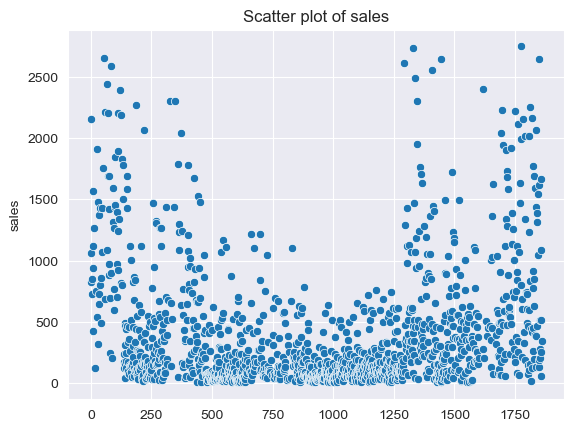

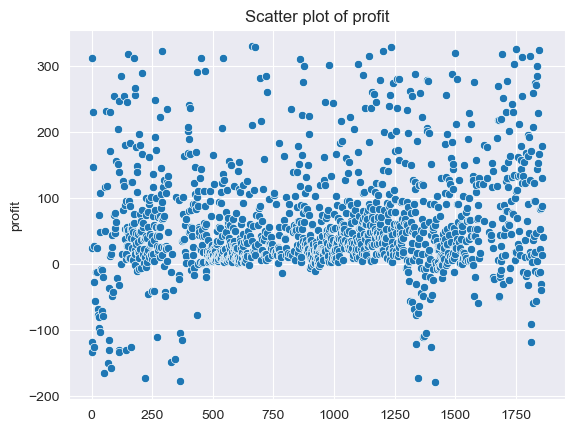

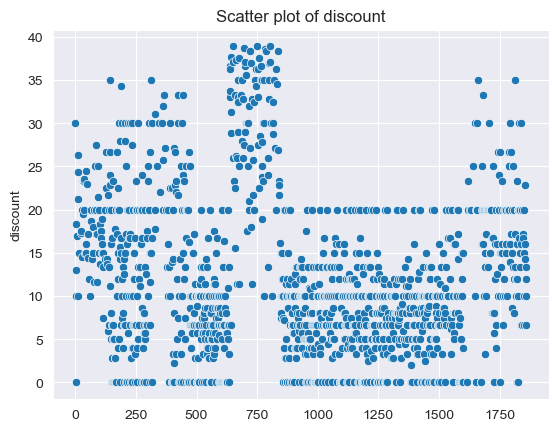

In [360]:
for column in df_mix_prod_clean.columns:
    if column != 'productid':
        sns.scatterplot(data=df_mix_prod_clean[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

## Scaler

In [361]:
# Rescaling the attributes
df_mix_prod_cat = df_mix_prod_clean[['sales', 'profit', 'discount']]

scaler = StandardScaler()

# fit transform
df_mix_prod_cat_scaled = scaler.fit_transform(df_mix_prod_cat)
df_mix_prod_cat_scaled.shape

df_mix_prod_cat_scaled = pd.DataFrame(df_mix_prod_cat_scaled)
df_mix_prod_cat_scaled.columns = [['sales', 'profit', 'discount']]
df_mix_prod_cat_scaled.head()

,sales,profit,discount
0,0.840785,-2.222319,2.018389
1,1.316819,-0.462152,-0.201897
2,3.483223,3.093262,0.131146
3,0.639334,-2.410964,0.722852
4,0.893639,2.087193,-1.312040


## Build Model

In [362]:
features = df_mix_prod_cat_scaled[['sales', 'profit', 'discount']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(features)

cluster_labels = kmeans.labels_
sorted(Counter(cluster_labels).items())

centroids = kmeans.cluster_centers_

## Visualize Model

In [367]:
fig = px.scatter_3d(df_mix_prod_cat, x="sales", y="profit", z="discount", color=kmeans.labels_)
fig.update_layout(autosize = True, width = 900, height = 800)
plotly.offline.iplot(fig, filename='simple-3d-scatter')